[Reference](https://pub.towardsai.net/time-series-clustering-for-stock-market-prediction-in-python-part-1-738ab6462f0e)

In [5]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 7.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [1]:
# data manipulation
import pandas as pd 
import numpy as np

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# time and date libs
import datetime

# stock data access
import pandas_datareader as pdr

In [2]:
def get_data(ticker: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Get stock data input ticker
    """
    data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
    return data
  
# get 1000 days of data for Apple starting from today
start_date = datetime.datetime.now() - datetime.timedelta(days=1000)
end_date = datetime.datetime.now()

data = get_data('AAPL', start_date=start_date, end_date=end_date)

data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-18,66.857498,66.057503,66.449997,66.775002,86703200.0,65.526497
2019-11-19,67.000000,66.347504,66.974998,66.572502,76167200.0,65.327766
2019-11-20,66.519997,65.099998,66.385002,65.797501,106234400.0,64.567284
2019-11-21,66.002502,65.294998,65.922501,65.502502,121395200.0,64.277786
2019-11-22,65.794998,65.209999,65.647499,65.445000,65325200.0,64.221352


In [3]:
def split_time_series(series, n):
    """
    Split a time series into n segments of equal size
    """
    split_series = [series[i:i+n] for i in range(0, len(series), n)]
    # if the last sequence is smaller than n, we discard it
    if len(split_series[-1]) < n:
        split_series = split_series[:-1]
    return np.array(split_series)

In [4]:
def split_sequence(sequence, k):
    """
    Split a sequence in two, where k is the size of the first sequence
    """
    return np.array(sequence[:int(len(sequence) * k)]), np.array(sequence[int(len(sequence) * k):])


def split_sequences(sequences, k=0.80):
    """
    Applies split_sequence on all elements of a list or array
    """
    return [split_sequence(sequence, k) for sequence in sequences]

In [5]:
N = 15  # window size --> we can tweak it and test different options
K = 0.70 # split size --> 80% of the data is in A, 20% in B

SEQS = split_time_series(list(data['Close'].values), N) # creates sequences of length N

SPLIT_SEQS = split_sequences(SEQS, K) # splits sequences into individual sequences

A = [seq[0] for seq in SPLIT_SEQS]
B = [seq[1] for seq in SPLIT_SEQS]

In [6]:
def compute_correlation(a1, a2):
    """
    Calculate the correlation between two vectors
    """
    return np.corrcoef(a1, a2)[0, 1]

def compute_dynamic_time_warping(a1, a2):
    """
    Compute the dynamic time warping between two sequences
    """
    
    DTW = {}

    for i in range(len(a1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(a2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(a1)):
        for j in range(len(a2)):
            dist = (a1[i]-a2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(a1)-1, len(a2)-1])


# create empty matrix
S = np.zeros((len(A), len(A)))

# populate S
for i in range(len(A)):
    for j in range(len(A)):
        # weigh the dynamic time warping with the correlation
        S[i, j] = compute_dynamic_time_warping(A[i], A[j]) * (1 - compute_correlation(A[i], A[j]))

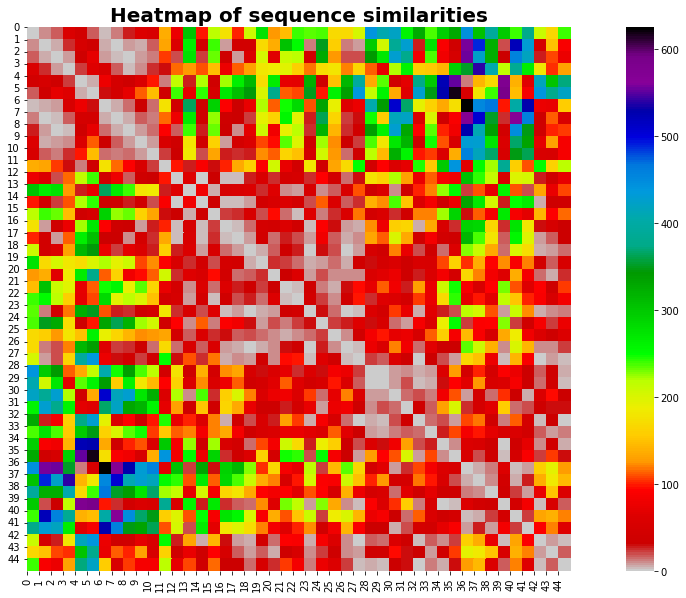

In [7]:
# plot heatmap of S
fig, ax = plt.subplots(figsize=(20, 10))  
sns.heatmap(S, cmap='nipy_spectral_r', square=True, ax=ax)
plt.title("Heatmap of sequence similarities", fontsize=20, fontweight='bold')
plt.xticks(range(len(A)), range(len(A)))
plt.yticks(range(len(A)), range(len(A)))
plt.show()

In [8]:
# populate G
G = {}
THRESHOLD = 6 # arbitrary value - tweak this to get different results

for i in range(len(S)):
    G[i] = []
    for j in range(len(S)):
        if S[i, j] < THRESHOLD and i != j and (i, j) not in G and (j, i) not in G and j not in G[i]:
            G[i].append(j)

# remove any empty groups
G = {k: v for k, v in G.items() if v}

In [9]:
def classify_trend(b, threshold=0.05):
    """
    Classify the trend of a vector
    """
    # compute slope
    slope = np.mean(np.diff(b) / np.diff(np.arange(len(b))))
    # if slope is positive, the trend is upward
    if slope + (slope * threshold) > 0:
        return 1
    # if slope is negative, the trend is downward
    elif slope - (slope * threshold) < 0:
        return -1
    # if slope is close to 0, the trend is flat
    else:
        return 0
        
# flatten list
flattened_G = [item for sublist in G.values() for item in sublist]
trends = [classify_trend(B[i]) for i in flattened_G]

# what is the probability of seeing a trend given the A sequence?
PROBABILITIES = {}

for k, v in G.items():
    for seq in v:
        total = len(v)
        seq_trends = [classify_trend(B[seq]) for seq in v]
        prob_up = len([t for t in seq_trends if t == 1]) / total
        prob_down = len([t for t in seq_trends if t == -1]) / total
        prob_stable = len([t for t in seq_trends if t == 0]) / total
        PROBABILITIES[k] = {'up': prob_up, 'down': prob_down, 'stable': prob_stable}
       
# Let's pack all in a Pandas DataFrame for an easier use
probs_df = pd.DataFrame(PROBABILITIES).T
# create a column that contains the number of elements in the group
probs_df['n_elements'] = probs_df.apply(lambda row: len(G[row.name]), axis=1)
probs_df.sort_values(by=["n_elements"], ascending=False, inplace=True)